# Tugas Akhir DIMAS



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create Dataset

Unzip dataset dari drive

In [ ]:
import os
from IPython.display import clear_output 

In [ ]:
!unzip /content/drive/Shareddrives/DIMAS/dataset.zip
clear_output()

# Init

Import hal-hal yang dibutuhkan program

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
from torch import optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import time
import os

cudnn.benchmark = True
plt.ion()   # interactive mode

print("Using torch", torch.__version__)
torch.manual_seed(42) # Setting the seed

Using torch 1.13.0+cu116


# Prepare Dataset and Functions

Membuat dataset generator dan augmentasi

In [ ]:
BATCH_SIZE = 8
IMG_SIZE = 128

# Proses augmentasi pada dataset training
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(10, (0.2, 0.2), (0.85, 1.15)),
        transforms.RandomAutocontrast(0.3),
        transforms.ToTensor(),
    ]),

    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ]),
}
# sesuaikan untuk menuju folder dataset
data_dir = "/content/content/drive/Shareddrives/DIMAS/dataset"


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# Class yang ada pada dataset
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

Mencoba menampilkan gambar yang sudah diaugmentasi

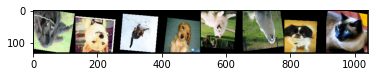

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fungsi untuk menampilkan gambar
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Mengambil gambar pada dataset
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

# Menampilkan gambar
imshow(torchvision.utils.make_grid(images))

# Model Init

Membuat model Ensemble EfficientNet

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import copy
from tqdm import tqdm
import time

class EnsembleEffNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.effnet1 = torchvision.models.efficientnet_b7()
        # Menghilangkan layer klasifikasi karena ingin menjumlahkan fitur yang didapatkan
        self.effnet1.classifier = nn.Sequential(
                )
        self.effnet2 = torchvision.models.efficientnet_b7()
        self.effnet2.classifier = nn.Sequential(
                )
        self.effnet3 = torchvision.models.efficientnet_b7()
        self.effnet3.classifier = nn.Sequential(
                )
        self.do = nn.Dropout(p=0.5, inplace=False)
        self.fc = nn.Linear(in_features=2560, out_features=len(class_names))
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        x1 = self.effnet1(x)
        x2 = self.effnet2(x)
        x3 = self.effnet3(x)
        x = x1 + x2 + x3
        x = self.fc(self.do(x))
        return x

Fungsi untuk melatih model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, last_epoch=0, last_acc=0):
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []
    best_epoch = last_epoch
    best_acc = last_acc
    since = time.time()
    avg_acc = 0
    for epoch in range(num_epochs):  # Looping pada dataset
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_acc = 0

            if phase == 'train':
                model.train()  # Mengubah model agar bisa diatih
                acc_list = train_acc_list
                loss_list = train_loss_list
                loader = dataloaders['train']
            else:
                model.eval()   # Mengubah model agar tidak dapat dilatih dan hanya untuk inferensi
                loader = dataloaders['val']
                acc_list = val_acc_list
                loss_list = val_loss_list    

            with tqdm(loader, unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    tepoch.set_description(f"{phase} Epoch {last_epoch + epoch + 1}")

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        # Hasil dari klasifier perlu dimasukkan ke fungsi softmax dan diambil nilai tertinggi sebagai label
                        _, preds = torch.max(F.softmax(outputs, 1), 1)
                        loss = criterion(outputs, labels.cuda())

                    # backpropagation dan optimisasi saat fase training
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_acc += torch.sum(preds == labels.cuda()).item()
                    tepoch.set_postfix(loss= str(f'{(running_loss/len(loader.dataset)):.4f}'), accuracy= str(f'{(running_acc/len(loader.dataset)):.4f}'))
                    time.sleep(0.1)
            avg_acc = round(running_acc/len(loader.dataset), 4)
            acc_list.append(running_acc/len(loader.dataset))
            loss_list.append(running_loss/len(loader.dataset))

            # Menyimpan dataset jika akurasi validasi lebih tinggi dari akurasi sebelumnya
            if phase == 'val' and avg_acc > best_acc:
                    best_acc = avg_acc
                    best_epoch = last_epoch + epoch + 1
                    state = {
                      'epoch': best_epoch,
                      'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'scheduler': scheduler.state_dict(),
                      'accuracy' : best_acc
                    }
                    torch.save(state, f"/content/drive/Shareddrives/DIMAS/Checkpoint/state_{best_acc}_{best_epoch}.pt")
           
        if phase == 'train':
          scheduler.step()

        # Menyimpan checkpoint setiap 2 epoch
        if ((last_epoch + epoch + 1) % 2 == 0):
          state = {
              'epoch': last_epoch + epoch + 1,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'scheduler': scheduler.state_dict(),
              'accuracy' : avg_acc
          }
          torch.save(state, "/content/drive/Shareddrives/DIMAS/Checkpoint/state.pt")

    print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc}')

    return model, {'train_acc': train_acc_list, 'train_loss': train_loss_list,
                   'val_acc': val_acc_list, 'val_loss': val_loss_list,
                   'best_epoch': best_epoch, 'best_acc': best_acc}

Fungsi untuk memprediksi data testing

In [ ]:
def test_model(model):
    y_true = []
    y_pred = []
    model.eval()
    with tqdm(dataloaders["test"], unit="batch") as tepoch:
      for inputs, labels in tepoch:
        with torch.no_grad():
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            # Hasil dari klasifier perlu dimasukkan ke fungsi softmax dan diambil nilai tertinggi sebagai label
            _, preds = torch.max(F.softmax(outputs, 1), 1)
            y_true = np.concatenate([y_true, labels.cpu()])
            y_pred = np.concatenate([y_pred, preds])
    return y_true, y_pred

Fungsi untuk mengevaluasi model

In [ ]:
from sklearn.metrics import precision_score, \
    recall_score, classification_report, \
    accuracy_score, f1_score, ConfusionMatrixDisplay

def evaluate_classifier_performance(y_true, y_pred):
    # Informasi evaluasi secara compact
    print("Hasil Evaluasi:\n\n%s\n" % (classification_report(y_true, y_pred, target_names=class_names)))

    # Hasil evaluasi yang lebih lengkap
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision Macro Average:', precision_score(y_true, y_pred, average='macro'))
    print('Precision Micro Average:', precision_score(y_true, y_pred, average='micro'))
    print('Recall Macro Average:', recall_score(y_true, y_pred, average='macro'))
    print('Recall Micro Average:', recall_score(y_true, y_pred, average='micro'))
    print('F1 Macro Average:', f1_score(y_true, y_pred, average='macro'))
    print('F1 Micro Average:', f1_score(y_true, y_pred, average='micro'))

# Training model

Membuat model dengan optimizer dan fungsi loss

In [ ]:
import torch.optim as optim
model = EnsembleEffNet()
model.to(device)
# Menggunakan cross entropy sebagai loss function karena klasifikasi
criterion = nn.CrossEntropyLoss()
# Menggunakan stochastic gradient descent sebagai fungsi optimisasi
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum=0.9, nesterov=True)
# Scheduler untuk mengurangi learning rate jika akurasi tidak bertambah
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Memuat *weights* model yang sudah disimpan agar bisa digunakan kembali.

In [ ]:
# Memasukkan weight model yang sudah disimpan sebelumnya
# state = torch.load("/content/drive/Shareddrives/DIMAS/Checkpoint/state.pt")
state = torch.load("/content/drive/Shareddrives/DIMAS/Checkpoint/sgd/state_0.6694_222.pt")
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])
lr_scheduler.load_state_dict(state['scheduler'])
epoch = state['epoch']
acc = state['accuracy']

Melatih model

In [ ]:
model, info = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=30, last_epoch=epoch, last_acc=acc)

val Epoch 250: 100%|██████████| 93/93 [00:22<00:00,  4.16batch/s, accuracy=0.6314, loss=2.0207]



Training complete in 254m 13s
Best val Acc: 0.6694


Memprediksi model

In [ ]:
y_true, y_pred = test_model(model)

100%|██████████| 93/93 [00:12<00:00,  7.32batch/s]


Hasil Evaluasi

In [ ]:
evaluate_classifier_performance(y_true, y_pred)

Hasil Evaluasi:

                            precision    recall  f1-score   support

                Abyssinian       0.70      0.67      0.68        21
          American Bulldog       0.64      0.70      0.67        20
 American Pit Bull Terrier       0.22      0.10      0.14        20
              Basset Hound       0.73      0.55      0.63        20
                    Beagle       0.50      0.60      0.55        20
                    Bengal       0.60      0.75      0.67        20
                    Birman       0.65      0.75      0.70        20
                    Bombay       1.00      0.85      0.92        20
                     Boxer       0.41      0.75      0.53        20
         British Shorthair       0.61      0.55      0.58        20
                 Chihuahua       0.33      0.30      0.32        20
              Egyptian Mau       0.78      0.70      0.74        20
    English Cocker Spaniel       0.76      0.65      0.70        20
            English Setter    